<a href="https://colab.research.google.com/github/Alpha-mon/AI-RoboAdvisor/blob/main/PortfolioOptimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

보유하고 있는 주식의 티커 목록을 쉼표로 구분하여 입력하세요 (예: AAPL,GOOGL,MSFT): 005930.KS,LPL,NVDA
Epoch 1/100
159/159 - 1s - loss: 0.0313 - 1s/epoch - 9ms/step
Epoch 2/100
159/159 - 0s - loss: 0.0277 - 261ms/epoch - 2ms/step
Epoch 3/100
159/159 - 0s - loss: 0.0251 - 251ms/epoch - 2ms/step
Epoch 4/100
159/159 - 0s - loss: 0.0255 - 263ms/epoch - 2ms/step
Epoch 5/100
159/159 - 0s - loss: 0.0263 - 266ms/epoch - 2ms/step
Epoch 6/100
159/159 - 0s - loss: 0.0247 - 275ms/epoch - 2ms/step
Epoch 7/100
159/159 - 0s - loss: 0.0253 - 268ms/epoch - 2ms/step
Epoch 8/100
159/159 - 0s - loss: 0.0255 - 264ms/epoch - 2ms/step
Epoch 9/100
159/159 - 0s - loss: 0.0260 - 245ms/epoch - 2ms/step
Epoch 10/100
159/159 - 0s - loss: 0.0245 - 242ms/epoch - 2ms/step
Epoch 11/100
159/159 - 0s - loss: 0.0243 - 254ms/epoch - 2ms/step
Epoch 12/100
159/159 - 0s - loss: 0.0244 - 275ms/epoch - 2ms/step
Epoch 13/100
159/159 - 0s - loss: 0.0243 - 300ms/epoch - 2ms/step
Epoch 14/100
159/159 - 0s - loss: 0.0253 - 331ms/epoch - 2ms/step
Epoch 15/100


1/1 [==============================] - 1s 691ms/step


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44050 (\N{HANGUL SYLLABLE GABS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51452 (\N{HANGUL SYLLABLE JU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49885 (\N{HANGUL SYLLABLE SIG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50696 (\N{HANGUL SYLLABLE YE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages

최적의 주식 비중:
005930.KS: 0.18
LPL: 0.20
NVDA: 0.63


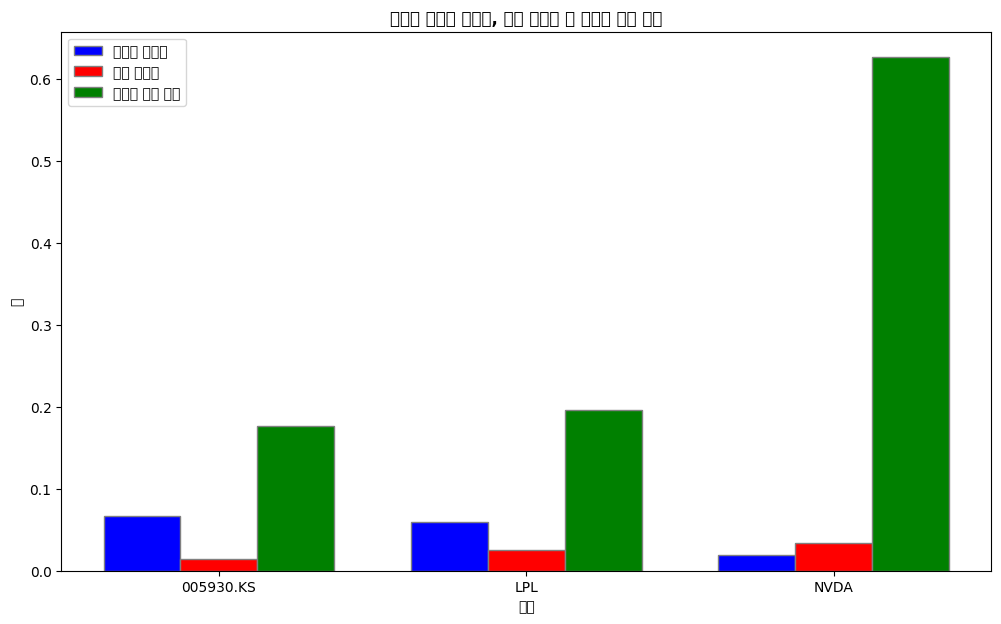


추천 주식 비중:
005930.KS: 17.67%
LPL: 19.67%
NVDA: 62.66%


In [6]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# 사용자로부터 보유 주식 입력 받기
stock_list = input("보유하고 있는 주식의 티커 목록을 쉼표로 구분하여 입력하세요 (예: AAPL,GOOGL,MSFT): ").split(",")
stock_list = [stock.strip() for stock in stock_list]

import yfinance as yf

# 주식 데이터 가져오기
def fetch_data(tickers):
    data = {}
    for ticker in tickers:
        stock_data = yf.Ticker(ticker)
        data[ticker] = stock_data.history(period="1y")  # 최근 1년간의 데이터 가져오기
    return data

stock_data = fetch_data(stock_list)

from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# 수익률 및 변동성 계산
returns = {}
for stock, data in stock_data.items():
    prices = data['Close'].values.astype(float)
    daily_returns = prices[1:] / prices[:-1] - 1
    returns[stock] = daily_returns

# LSTM 모델 학습을 위한 데이터 준비
look_back = 5
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

# LSTM 모델 학습
models = {}
for stock, daily_returns in returns.items():
    # 데이터 정규화
    scaler = MinMaxScaler(feature_range=(0, 1))
    daily_returns = scaler.fit_transform(daily_returns.reshape(-1, 1))

    # 데이터 분할
    train_size = int(len(daily_returns) * 0.67)
    test_size = len(daily_returns) - train_size
    train, test = daily_returns[0:train_size, :], daily_returns[train_size:len(daily_returns), :]

    # LSTM에 필요한 데이터 형식으로 변환
    X_train, Y_train = create_dataset(train, look_back)
    X_test, Y_test = create_dataset(test, look_back)

    # LSTM 모델 구성
    model = Sequential()
    model.add(LSTM(50, input_shape=(X_train.shape[1], 1)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, Y_train, epochs=100, batch_size=1, verbose=2)

    # 모델 저장
    models[stock] = model

print("모든 주식에 대한 LSTM 모델 학습이 완료되었습니다.")


import numpy as np
from scipy.optimize import minimize

# 각 주식의 예측된 변동성 계산
predicted_volatilities = {}
for stock, model in models.items():
    last_sequence = returns[stock][-look_back:]
    scaled_sequence = scaler.transform(last_sequence.reshape(-1, 1))
    predicted_return = model.predict(scaled_sequence.reshape(1, look_back, 1))
    predicted_volatility = scaler.inverse_transform(predicted_return)[0][0]
    predicted_volatilities[stock] = predicted_volatility

# 리스크 기여도를 동일하게 하는 최적의 주식 비중 계산 함수
def risk_parity_objective(weights, volatilities):
    # 각 주식의 리스크 기여도 계산
    risk_contributions = [vol * weight for vol, weight in zip(volatilities, weights)]
    total_portfolio_volatility = np.sum(risk_contributions)
    risk_contributions = [rc / total_portfolio_volatility for rc in risk_contributions]

    # 리스크 기여도 간의 편차를 최소화하는 것이 목표
    target_risk_contribution = 1 / len(volatilities)
    return sum([(rc - target_risk_contribution)**2 for rc in risk_contributions])

# 최적화 시작
initial_weights = [1/len(stock_list) for _ in stock_list]
bounds = [(0, 1) for _ in stock_list]
constraints = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}
optimized = minimize(risk_parity_objective, initial_weights, args=(list(predicted_volatilities.values()),),
                     method='SLSQP', bounds=bounds, constraints=constraints)

# 최적의 주식 비중 출력
optimal_weights = optimized.x
print("최적의 주식 비중:")
for stock, weight in zip(stock_list, optimal_weights):
    print(f"{stock}: {weight:.2f}")

    import matplotlib.pyplot as plt

# 실제 변동성 계산
actual_volatilities = {stock: data['Close'].pct_change().std() for stock, data in stock_data.items()}

# 그래프 그리기
stocks = list(stock_data.keys())
predicted_vols = [predicted_volatilities[stock] for stock in stocks]
actual_vols = [actual_volatilities[stock] for stock in stocks]
weights = [weight for weight in optimal_weights]

barWidth = 0.25
r1 = np.arange(len(stocks))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

plt.figure(figsize=(12,7))

# 바 차트 생성
plt.bar(r1, predicted_vols, width=barWidth, color='blue', edgecolor='grey', label='예측된 변동성')
plt.bar(r2, actual_vols, width=barWidth, color='red', edgecolor='grey', label='실제 변동성')
plt.bar(r3, weights, width=barWidth, color='green', edgecolor='grey', label='최적의 주식 비중')

# 그래프 제목 및 축 이름 설정
plt.title('주식별 예측된 변동성, 실제 변동성 및 최적의 주식 비중', fontweight='bold')
plt.xlabel('주식', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(stocks))], stocks)
plt.ylabel('값', fontweight='bold')

# 범례 표시
plt.legend()

# 그래프 표시
plt.show()

def recommend_weights(optimal_weights, stocks):
    print("\n추천 주식 비중:")
    for stock, weight in zip(stocks, optimal_weights):
        print(f"{stock}: {weight:.2%}")

recommend_weights(weights, stocks)

In [7]:
print(actual_volatilities)

{'005930.KS': 0.014657872221429275, 'LPL': 0.024851936559823554, 'NVDA': 0.03394189882574205}
